# Implementing a Neural Network
In this exercise we will develop a neural network with fully-connected layers to perform classification, and test it out on the CIFAR-10 dataset.

In [1]:
# A bit of setup
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import pixiedust

from ie590.classifiers.neural_net import TwoLayerNet

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

Pixiedust database opened successfully


We will use the class `TwoLayerNet` in the file `ie590/classifiers/neural_net.py` to represent instances of our network. The network parameters are stored in the instance variable `self.params` where keys are string parameter names and values are numpy arrays. Below, we initialize toy data and a toy model that we will use to develop your implementation.

In [2]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

# Forward pass: compute scores
Open the file `ie590/classifiers/neural_net.py` and look at the method `TwoLayerNet.loss`. This function is very similar to the loss functions you have written for the SVM and Softmax exercises: It takes the data and weights and computes the class scores, the loss, and the gradients on the parameters. 

Implement the first part of the forward pass which uses the weights and biases to compute the scores for all inputs.

In [3]:
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
    [-0.20202237, -0.3826274,  -0.37823944],
    [-0.09999725, -0.29461579, -0.298211  ],
    [-0.04333782, -0.29038971, -0.3097813 ],
    [-0.0305597,  -0.26184001, -0.30413287],
    [-0.02637045, -0.24190783, -0.29750761]])
print(correct_scores)
print()

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-0.20202237 -0.3826274  -0.37823944]
 [-0.09999725 -0.29461579 -0.298211  ]
 [-0.04333782 -0.29038971 -0.3097813 ]
 [-0.0305597  -0.26184001 -0.30413287]
 [-0.02637045 -0.24190783 -0.29750761]]

correct scores:
[[-0.20202237 -0.3826274  -0.37823944]
 [-0.09999725 -0.29461579 -0.298211  ]
 [-0.04333782 -0.29038971 -0.3097813 ]
 [-0.0305597  -0.26184001 -0.30413287]
 [-0.02637045 -0.24190783 -0.29750761]]

Difference between your scores and correct scores:
3.399786567201413e-08


# Forward pass: compute loss
In the same function, implement the second part that computes the data and regularizaion loss.

In [4]:
# %%pixie_debugger
loss, _ = net.loss(X, y, reg=0.05)
correct_loss = 1.182247980

# should be very small, we get < 1e-12
print('Difference between your loss and correct loss:')
print(loss) # Salazar
print(np.sum(np.abs(loss - correct_loss)))

Difference between your loss and correct loss:
1.1822479803941373
3.9413716734770787e-10


# Backward pass
Implement the rest of the function. This will compute the gradient of the loss with respect to the variables `W1`, `b1`, `W2`, and `b2`. Now that you (hopefully!) have a correctly implemented forward pass, you can debug your backward pass using a numeric gradient check:

In [5]:
from ie590.gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.05)

# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 1.126755e-08
W2 max relative error: 9.431406e-10
b1 max relative error: 1.925197e-07
b2 max relative error: 5.553985e-11


# Train the network
To train the network we will use stochastic gradient descent (SGD), similar to the SVM and Softmax classifiers. Look at the function `TwoLayerNet.train` and fill in the missing sections to implement the training procedure. This should be very similar to the training procedure you used for the SVM and Softmax classifiers. You will also have to implement `TwoLayerNet.predict`, as the training process periodically performs prediction to keep track of accuracy over time while the network trains.

Once you have implemented the method, run the code below to train a two-layer network on toy data. You should achieve a training loss less than 0.2.

Final training loss:  0.1133638336182375


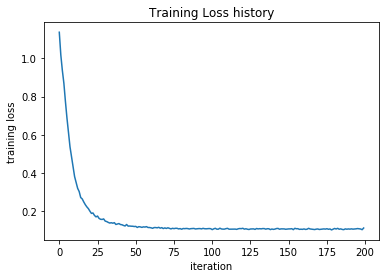

In [6]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=5e-1, reg=5e-6,
            num_iters=200, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

# Load the data
Now that you have implemented a two-layer network that passes gradient checks and works on toy data, it's time to load up our favorite CIFAR-10 data so we can use it to train a classifier on a real dataset.

In [7]:
from ie590.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'ie590/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


# Train a network
To train our network we will use SGD with momentum. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

In [55]:
input_size = 32 * 32 * 3
hidden_size = 60
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=5e-3, learning_rate_decay=0.95,
            reg=2e-01, verbose=False)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)



0.31
Validation accuracy:  0.306


# Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.29 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

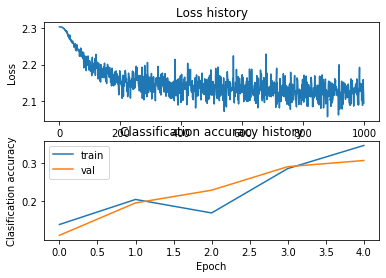

In [9]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.legend() # Salazar
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

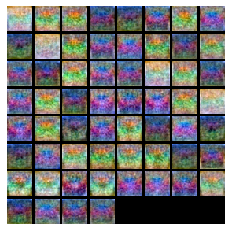

In [10]:
from ie590.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(net)

# Tune your hyperparameters

**What's wrong?**. Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, numer of training epochs, and regularization strength. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 28% on the validation set. 

**Experiment**: You goal in this exercise is to get as good of a result on CIFAR-10 as you can, with a fully-connected Neural Network. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

In [80]:
# %%pixie_debugger
best_net = None # store the best model into this 
from itertools import product as iterprod
#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_net.                                                            #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on the previous exercises.                          #
#################################################################################
#                          START OF YOUR CODE                                   #
#################################################################################
# pass ## Write your code here
best_acc = -1

# Hyperparameters
hidden_size = list(range(80,121,20))
learning_rate = [5e-2,1e-2,5e-3, 1e-3]
learning_rate_decay = []
reg = np.arange(0.05,0.16,0.05)
# combinations of hyperparameters
hyperCombs = list(iterprod(learning_rate, reg))
totalCombs = len(hyperCombs) * len(hidden_size)
val_acc = np.zeros(totalCombs)
n = 0

# sweeping through all combinations
for hs in hidden_size:    
    # defining hidden layers in network
    net_tune = TwoLayerNet(input_size, hs, num_classes)
    for hC in hyperCombs:
        # train
        net_tune.train(X_train, y_train, X_val, y_val,
            num_iters=2000, batch_size=200,
            learning_rate=hC[0], learning_rate_decay=0.95,
            reg=hC[1], verbose=False)
        # accuracy
#         val_acc = acc_data['val_acc_history'][-1]
        val_acc = (net_tune.predict(X_val) == y_val).mean()

        # yay!
        if val_acc > best_acc:
            best_net = net_tune
            best_acc = val_acc
        # print    
        n += 1
        print ('[%02d/%d]  HS: %03d learning_rate:%8.1E  reg:%8.1E ---> %f' % (n,totalCombs,hs,hC[0],hC[1],val_acc))
#################################################################################
#                               END OF YOUR CODE                                #
#################################################################################

[01/36]  HS: 080 learning_rate: 5.0E-02  reg: 5.0E-02 ---> 0.363000
[02/36]  HS: 080 learning_rate: 5.0E-02  reg: 1.0E-01 ---> 0.339000
[03/36]  HS: 080 learning_rate: 5.0E-02  reg: 1.5E-01 ---> 0.325000
[04/36]  HS: 080 learning_rate: 1.0E-02  reg: 5.0E-02 ---> 0.400000
[05/36]  HS: 080 learning_rate: 1.0E-02  reg: 1.0E-01 ---> 0.394000
[06/36]  HS: 080 learning_rate: 1.0E-02  reg: 1.5E-01 ---> 0.370000
[07/36]  HS: 080 learning_rate: 5.0E-03  reg: 5.0E-02 ---> 0.398000
[08/36]  HS: 080 learning_rate: 5.0E-03  reg: 1.0E-01 ---> 0.391000
[09/36]  HS: 080 learning_rate: 5.0E-03  reg: 1.5E-01 ---> 0.375000
[10/36]  HS: 080 learning_rate: 1.0E-03  reg: 5.0E-02 ---> 0.403000
[11/36]  HS: 080 learning_rate: 1.0E-03  reg: 1.0E-01 ---> 0.399000
[12/36]  HS: 080 learning_rate: 1.0E-03  reg: 1.5E-01 ---> 0.392000
[13/36]  HS: 100 learning_rate: 5.0E-02  reg: 5.0E-02 ---> 0.375000
[14/36]  HS: 100 learning_rate: 5.0E-02  reg: 1.0E-01 ---> 0.350000
[15/36]  HS: 100 learning_rate: 5.0E-02  reg: 1.

Best accuracy: 0.313000


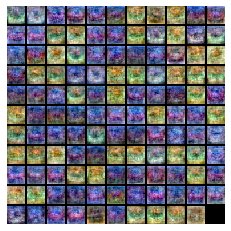

In [72]:
# visualize the weights of the best network
print('Best accuracy: %f' %(best_acc))
show_net_weights(best_net)

# Run on the test set
When you are done experimenting, you should evaluate your final trained network on the test set; you should get above 36%.

In [73]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.319
